# Анализ лояльности пользователей

Представитель нескольких брендов хочет протестировать программу лояльности.

Необходимо отобрать подходящие для программы бренды и покупателей, наиболее лояльных этим брендам

### 1. Предобработка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv', encoding='windows-1251')
df.head()

,Unnamed: 0,tk,pl,dia,hs,tc,cta,id_art,id_subsubfam,id_subfam,...,id_famn,id_seccion,id_subagr,id_agr,vta,uni,id_artn,art_sp,fam_sp,fam_en
0,1242,120071109002055793,1,2007/11/09,0.505729,110000761,11000076,21895,101070640100,1010706401,...,10107064,10107,101,1,0.68,1.0,21895,MARAVILLA 500 G Store_Brand,PASTA ALIMENTICIA SE,pasta
1,1243,120070601004053633,1,2007/06/01,0.588519,110000761,11000076,21816,101070640100,1010706401,...,10107064,10107,101,1,0.38,1.0,21816,FIDEO CABELLIN 500 G Store_Brand,PASTA ALIMENTICIA SE,pasta
2,1244,120070928004076410,1,2007/09/28,0.785498,28491841,2849184,562840,101070640100,1010706401,...,10107064,10107,101,1,1.55,2.0,562840,SPAGUETTI Nє 5 500 G Brand_1,PASTA ALIMENTICIA SE,pasta
3,1245,120070616003074261,1,2007/06/16,0.550961,95931501,9593150,28914,101070640100,1010706401,...,10107064,10107,101,1,1.03,2.0,28914,FIDEO FIDEUБ 500 Brand_7,PASTA ALIMENTICIA SE,pasta
4,1246,120070519001018477,1,2007/05/19,0.804954,93265591,9326559,159867,101070640100,1010706401,...,10107064,10107,101,1,1.09,1.0,159867,MACARRONES GRATINAR 5 Brand_2,PASTA ALIMENTICIA SE,pasta


In [3]:
df.shape

(48129, 21)

In [4]:
df.dtypes

Unnamed: 0        int64
tk               object
pl                int64
dia              object
hs              float64
tc                int64
cta               int64
id_art            int64
id_subsubfam      int64
id_subfam         int64
id_fam            int64
id_famn           int64
id_seccion        int64
id_subagr         int64
id_agr            int64
vta             float64
uni             float64
id_artn           int64
art_sp           object
fam_sp           object
fam_en           object
dtype: object

Для дальнейше работы нам понадобятся id пользователя и наименование товара.

Отберем эти колонки и переименуем их для комфортной работы.

In [5]:
user_df = df[['tc', 'art_sp']]
user_df = user_df.rename(columns={'tc': 'user_id', 'art_sp' : 'brand_info'})

Наша задача исследовать лояльность брендам, отберем их наименование из названия товара.

In [6]:
user_df['brand_name']= user_df.brand_info.apply(lambda x: x.split(' ')[-1])
user_df.head()

,user_id,brand_info,brand_name
0,110000761,MARAVILLA 500 G Store_Brand,Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand,Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1,Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7,Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2,Brand_2


### 2. Исследовательский анализ данных

Для того чтобы оценить лояльность покупателя необходимы данные о некоторм количестве его покупок, на основании 1-2 покупок выводы сделать невозможно. 

Посчитаем количество покупок для каждого юзера и посмотрим описательные статистики этих данных:

In [7]:
user_purchases =user_df.groupby('user_id', as_index=False)\
                       .agg({'brand_name' : 'count'}) \
                       .rename(columns={'brand_name' : 'purchases'})
user_purchases.describe()

,user_id,purchases
count,1.176400e+04,11764.000000
mean,7.690517e+07,4.091210
std,1.622210e+08,4.573143
min,-1.236395e+09,1.000000
25%,1.503761e+07,1.000000
50%,4.682179e+07,2.000000
75%,9.311601e+07,5.000000
max,1.408849e+09,60.000000


Мы видим, что медианное количество покупок 2, этого явно мало для наших целей. 75-й процентиль = 5, то есть 25% покупателей сделало 5 и более покупок. Возьмем это количество для анализа лояльности в первом приближении.

In [8]:
user_purchases =  user_purchases.query('purchases >=5')
user_purchases.head()

,user_id,purchases
1,1031,6
2,4241,5
11,25971,7
14,40911,27
16,45181,5


Рассчитаем количество уникальных брендов в покупках каждого юзера

In [9]:
user_unique_brands = user_df.groupby('user_id', as_index=False)\
                            .agg({'brand_name' : 'nunique'})\
                            .rename(columns={'brand_name' : 'unique_brands'})
user_unique_brands.head()

,user_id,unique_brands
0,-1236394515,1
1,1031,2
2,4241,2
3,17311,1
4,17312,2


На следующем шаге отберем самый популярный бренд для каждого пользователя и посчитаем количество покупок этого бренда

In [10]:
lovely_brand_purchases_df = user_df.groupby(['user_id', 'brand_name'], as_index=False)\
                                   .agg({'brand_info' : 'count'})\
                                   .sort_values(['user_id', 'brand_info'], ascending=[False, False])\
                                   .groupby('user_id')\
                                   .head(1)\
                                   .rename(columns={'brand_name':'lovely_brand', 'brand_info':'lovely_brand_purchases'})
lovely_brand_purchases_df.head()

,user_id,lovely_brand,lovely_brand_purchases
18187,1408849249,Store_Brand,1
18186,1408840919,Store_Brand,1
18185,1408832719,Brand_4,3
18184,1408825059,Brand_1,1
18183,1408817589,Store_Brand,2


Соберем посчитанные данные в единый датафрейм

In [11]:
loyalty_df = user_purchases.merge(user_unique_brands, on='user_id')\
                           .merge(lovely_brand_purchases_df, on='user_id')
loyalty_df.head()

,user_id,purchases,unique_brands,lovely_brand,lovely_brand_purchases
0,1031,6,2,Store_Brand,5
1,4241,5,2,Brand_4,3
2,25971,7,2,Store_Brand,5
3,40911,27,5,Brand_4,19
4,45181,5,4,Store_Brand,2


Самыми лояльными покупателями можно считать тех, кто ВСЕГДА отдает предпочтение только одному бренду.

In [12]:
loyal_users = loyalty_df[loyalty_df.unique_brands == 1]
loyal_users

,user_id,purchases,unique_brands,lovely_brand,lovely_brand_purchases
13,86281,14,1,Brand_4,14
18,94961,6,1,Brand_4,6
29,132061,9,1,Brand_4,9
30,134281,6,1,Brand_4,6
35,157311,12,1,Brand_4,12
...,...,...,...,...,...
3372,1010244089,9,1,Store_Brand,9
3374,1010247239,5,1,Brand_4,5
3376,1010274559,5,1,Brand_4,5
3377,1110091379,5,1,Brand_1,5


Максимально лояльных покупателей набралось 911 человек.

Для остальных нам нужно оценить степень лояльности, рассчитаем эту метрику как отношение количества покупок любимого бренда к общему количеству покупок.

In [13]:
loyalty_df['loyalty_score'] = loyalty_df.lovely_brand_purchases / loyalty_df.purchases
loyalty_df

,user_id,purchases,unique_brands,lovely_brand,lovely_brand_purchases,loyalty_score
0,1031,6,2,Store_Brand,5,0.833333
1,4241,5,2,Brand_4,3,0.600000
2,25971,7,2,Store_Brand,5,0.714286
3,40911,27,5,Brand_4,19,0.703704
4,45181,5,4,Store_Brand,2,0.400000
...,...,...,...,...,...,...
3378,1408767189,5,1,Brand_4,5,1.000000
3379,1408783189,10,2,Store_Brand,8,0.800000
3380,1408783379,6,2,Brand_1,4,0.666667
3381,1408798879,8,3,Store_Brand,4,0.500000


Остается неясным, как именно лояльность распределена по брендам. Для того, чтобы ответить на этот вопрос, визуализируем наши данные - построим диаграмму распределения скора лояльности

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


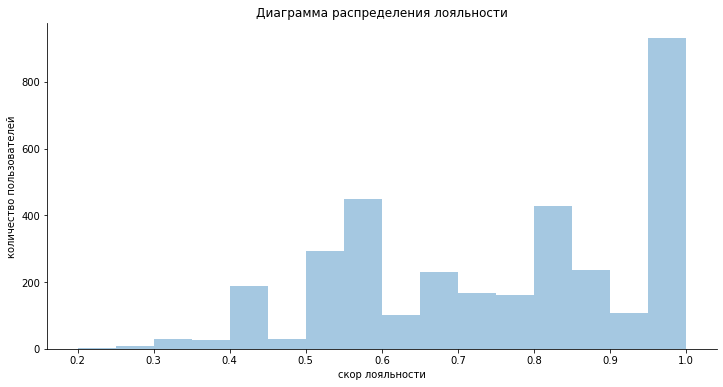

In [14]:
plt.figure(figsize=(12, 6))
sns.distplot(loyalty_df.loyalty_score, kde=False)
plt.title('Диаграмма распределения лояльности')
plt.xlabel('скор лояльности')
plt.ylabel('количество пользователей')
sns.despine()

Рассчитаем средний показатель (медиану) лояльности по брендам и количество приверженцев каждому бренду

In [15]:
brands_loyalty = loyalty_df.groupby('lovely_brand', as_index=False)\
                           .agg({'loyalty_score' : 'median', 'user_id' : 'count'})\
                           .rename(columns={'loyalty_score':'median_loyalty_score', 'user_id' : 'number_of_users'})\
                           .sort_values('median_loyalty_score', ascending=False)
brands_loyalty

,lovely_brand,median_loyalty_score,number_of_users
3,Brand_4,0.818182,2041
6,Store_Brand,0.750000,715
0,Brand_1,0.679487,410
1,Brand_2,0.600000,88
4,Brand_5,0.600000,5
2,Brand_3,0.500000,115
5,Brand_7,0.444444,9


Отобразим полученные данные графически

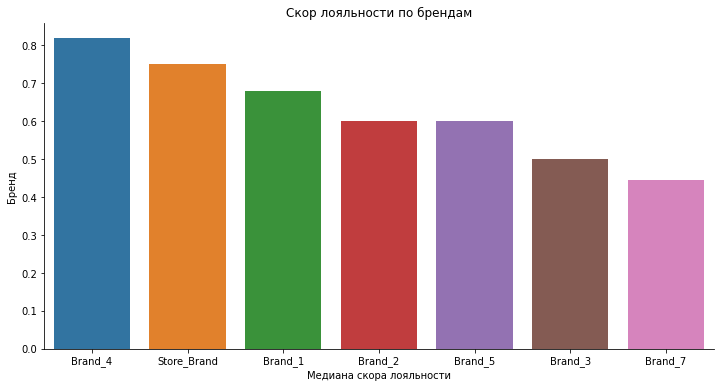

In [16]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='lovely_brand', y='median_loyalty_score', data=brands_loyalty)
plt.title('Скор лояльности по брендам')
plt.xlabel('Медиана скора лояльности')
plt.ylabel('Бренд')
sns.despine()

Видим, что наиболее высокий показатель лояльности имеет Brand_4, посмотрим так же на количество приверженцев брендов

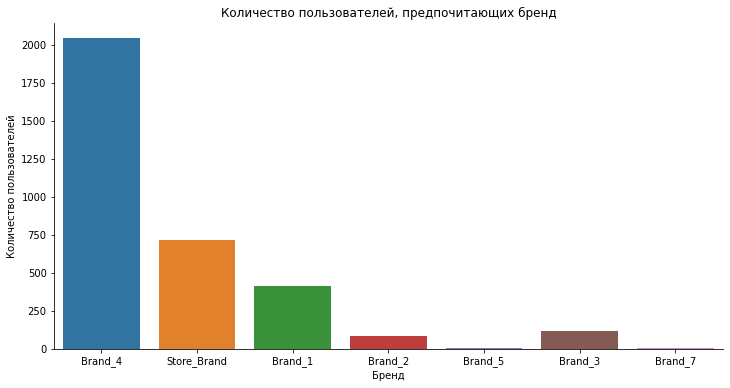

In [17]:
plt.figure(figsize=(12, 6))
ac = sns.barplot(x='lovely_brand', y='number_of_users', data=brands_loyalty)
plt.title('Количество пользователей, предпочитающих бренд')
plt.xlabel('Бренд')
plt.ylabel('Количество пользователей')
sns.despine()

Рассчитаем процент покупателей, отдающих предпочтение каждому бренду.

In [18]:
brands_loyalty['percent_users'] = round(brands_loyalty.number_of_users/brands_loyalty.number_of_users.sum()*100)
brands_loyalty

,lovely_brand,median_loyalty_score,number_of_users,percent_users
3,Brand_4,0.818182,2041,60.0
6,Store_Brand,0.750000,715,21.0
0,Brand_1,0.679487,410,12.0
1,Brand_2,0.600000,88,3.0
4,Brand_5,0.600000,5,0.0
2,Brand_3,0.500000,115,3.0
5,Brand_7,0.444444,9,0.0


Оказывается, большинство людей, проявляющих дояльность, проявляют её к Brand_4 (60% всех покутелей), а вот остальные бренды пользователи довольно редко выделяют в любимые. Это важная информация, возможно компании стоит пересмотреть подход к формированию остальных брендов.

Разворачивать программу лояльности рекомендовано для Brand_4.

In [19]:
loyalty_df.loyalty_score.describe()

count    3383.000000
mean        0.759356
std         0.198331
min         0.200000
25%         0.600000
50%         0.800000
75%         1.000000
max         1.000000
Name: loyalty_score, dtype: float64

Дальнейшая работа требует уточнения задачи, например, если планируется какая-то очень эксклюзивная программа с большими скидками и преимуществами, рассчитаная на самых лояльных клиентов, то оптимально будет отобрать только тех, чей показатель лояльности = 1 и возможно стоит изначально отобрать клиентов с бОльшим количеством покупок (в первом приближении мы оставили тех, кто совершил 5 и более покупок). 

Если же задача компании исследовать лояльность и условия планируются достаточно мягкие, то есть возможно предложить их большому количеству пользователей, можно отобрать тех, чей показатель лояльности >= 0,6 (это 25-й процентиль скора лояльности).